## Deep Unfolding applied to SPSA

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Zygote

In [2]:
function func(x)
    return x[1]^2 + 8*x[2]^2
end
# Define a simple test function (e.g., Rosenbrock function)
function rosen(x, a=1, b=100)
    return (a - x[1])^2 + b * (x[2] - x[1]^2)^2
end

rosen (generic function with 3 methods)

In [3]:
function spsa(x0, func; bounds=nothing, alpha=0.602, gamma=0.101, deltax_0=0.1, a=nothing, a_min=1.0e-6, c=1.0e-2, stepredf=0.5, gtol=1.0e-5, graditer=1, memsize=100, IniNfeval=0, maxiter=5000, adaptive_step=false, relaxation=true, dynamic_system=false, args...)
    redcounter = 0
    if !dynamic_system
        Npar = length(x0)
    else
        Npar = length(x0) - 1
    end

    function g_sa(x, func, ck, niter, args...)
        p = length(x)
        gsum = zeros(p)
        yp = 0.0
        ym = 0.0
        xp = copy(x)
        xm = copy(x)
        delta = zeros(p)

        if niter > 0
            buf=Zygote.Buffer(delta, p, niter)
            for m in 1:niter
                delta = 2 .* floor.(2 .* rand(p)) .- 1

                xp = x + ck .* delta
                xm = x - ck .* delta
                if dynamic_system
                    xp[end] = xm[end] = x[end]
                end
                yp = func(xp, args...)
                ym = func(xm, args...)
                buf[:,m] = (yp - ym) ./ (2 * ck .* delta)
            end
            gsum=sum(copy(buf),dims=2)
            ghat = gsum / niter
        else
            ghat = zeros(p)
        end
        if dynamic_system
            ghat[end] = 0
        end
        return ghat, yp, ym, xp, xm, delta
    end

    Xmax = Float64[]
    Xmin = Float64[]
    if bounds === nothing
        bounds = [(-10.0, 10.0) for _ in 1:Npar]
        # println("No bounds specified. Default:(-10,10).")
    end
    if length(bounds) != Npar
        error("Number of parameters Npar != length of bounds")
    end
    Xmin = [bounds[m][1] for m in 1:Npar]
    Xmax = [bounds[m][2] for m in 1:Npar]
    Nfeval = IniNfeval
    x0 = collect(x0)
    # history = []
    # historyx = []
    p = length(x0)
    A = Int(floor(0.1 * maxiter))
    y0 = func(x0, args...)
    Nfeval += 1
    mem = fill(y0, memsize)
    x = copy(x0)
    a_ini = 0.0
    # println("initial objective value = ", y0)
    x_best = copy(x0); y_best = y0;
    for k in 1:maxiter
        if dynamic_system
            x[end] = k
        end
        ck = c / (k + 1)^gamma
        ghat, yp, ym, xp, xm, delta = g_sa(x, func, ck, graditer, args...)
        Nfeval += graditer * 2
        if k == 1
            if a === nothing
                a = deltax_0 * (A + 1)^alpha / minimum(abs.(ghat[1:Npar]))
            end
            a_ini = a
            # println("ghat0 = ", ghat[:])
        end
        ak = a / (k + 1 + A)^alpha
        # println("k: $k, ym = $ym, yp = $yp, a = $a")
        xold = copy(x)
        x = x - ak .* ghat
        buf =Zygote.Buffer(x)
        for m in 1:Npar
            if x[m] < Xmin[m]
                buf[m] = Xmin[m]
            elseif x[m] > Xmax[m]
                buf[m] = Xmax[m]
            else
                buf[m] = x[m]
            end
        end
        x = copy(buf)
        y = func(x, args...)
        # push!(history, [Nfeval, y])
        # push!(historyx, copy(x))
        mem = vcat(mem[2:end], min(ym, yp))
        if ym < y_best
            x_best = xm
            y_best = ym
        end
        if yp < y_best
            x_best = xp
            y_best = yp
        end
        if adaptive_step

            if ((y0 - min(yp, ym)) < 0)
                println("divergence detected. reinitializing.")
                redcounter += 1
                x = copy(x_best)
                buf = Zygote.Buffer(a)
                buf = stepredf * a
                a = copy(buf)
                if (redcounter > Int(floor(0.05 * maxiter))) && relaxation
                    println("Too many divergence. Resetting a and relaxing threshold!")
                    a = a_ini
                    y0 = min(yp, ym)
                    redcounter = 0
                end
            end
        end
    end
    y = func(x, args...)
    Nfeval += 1
    println("achieved objective: ",y)
    # push!(history, [Nfeval, y])
    # push!(historyx, copy(x))
    # println("number of function evaluation: ", Nfeval)
    # return x, y, history, historyx, Nfeval
    return y
end

spsa (generic function with 1 method)

In [4]:
function train_spsa(opt, eta, max_itr, train_itr) #training eta of gradient descent
    ps = Flux.params(eta) 
    l = [] # will keep record of eta values in this list
    for i in 1:train_itr # perform gradient descent starting from train_iter random starting points
        push!(l,eta[1]) # like append in python
        x0=20*rand(2).-10
        gs = Flux.gradient(ps) do
            spsa(x0, rosen; a=eta, maxiter=max_itr) # perform gradient descent for max_itr iterations 
        end
        Flux.Optimise.update!(opt, ps, gs) # update ps = η train_iter times
        #spsa(x0, func; a=nothing, maxiter=max_itr)
    end  
    return l
end

train_spsa (generic function with 1 method)

achieved objective: 8.169426706249935
achieved objective: 616.2603432128211
achieved objective: 15.845369444730398
achieved objective: 7.45071573035359
achieved objective: 0.7950541910077134
achieved objective: 15.716027276378945
achieved objective: 0.6275484067770685
achieved objective: 15.431354718018444
achieved objective: 16.636952517686726
achieved objective: 0.6237401697930384
achieved objective: 0.6256281767264427
achieved objective: 1.4284681623431308
achieved objective: 2.7303724922321124
achieved objective: 3.4744285919550197
achieved objective: 16.89509964813866
achieved objective: 2.9854204707535015
achieved objective: 13.874774593767414
achieved objective: 2.911363536626361
achieved objective: 0.6177563465498277
achieved objective: 8.098330276560972
achieved objective: 0.4521741806873056
achieved objective: 0.6549244032800009
achieved objective: 4.166686122998181
achieved objective: 9.630425050796896
achieved objective: 2.9749376386894957
achieved objective: 1.887814416934

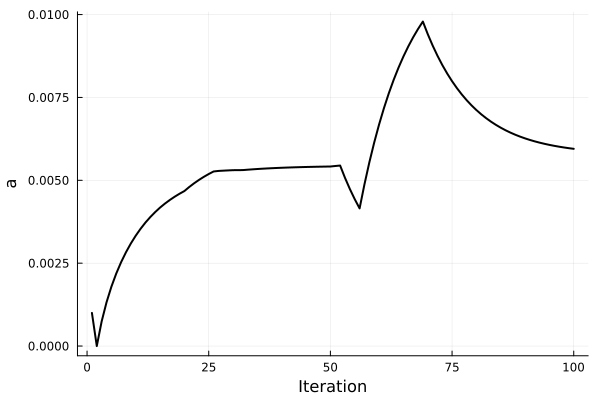

In [5]:
opt = Flux.ADAM(0.001) 
eta = [0.001]
max_itr = 5000 # number of gradient descent iterations
train_itr = 100 # number of different starting point for gradient descent to update η
l = train_spsa(opt, eta, max_itr, train_itr)
println("a: ",l)
plot(1:train_itr,l, xlabel="Iteration", ylabel="a",legend=false, lw=2,color=:black)

LoadError: syntax: extra token "__future__" after end of expression